In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, Flatten, Resizing, Rescaling, RandomFlip, RandomRotation, RandomBrightness, RandomContrast, RandomZoom
from keras.utils import image_dataset_from_directory
from keras import Sequential, Input
from keras.optimizers import Adam
from keras.applications import EfficientNetV2L
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from keras import callbacks
from torchvision import transforms
from keras.preprocessing import image
from PIL import Image
from keras.losses import SparseCategoricalCrossentropy as scc
import cv2
from keras_cv.layers import Grayscale
f'Tensorflow version: {tf.__version__}'

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using TensorFlow backend


'Tensorflow version: 2.12.0'

In [2]:
imagesize = 256
batchsize = 32
rand_seed = 10

train_ds = image_dataset_from_directory(
    '/kaggle/input/medical-scan-classification-dataset/Alzheimer/Alzheimer/MRI',
    image_size = (imagesize, imagesize),
    color_mode = 'rgb',
    batch_size = batchsize,
    validation_split = 0.2,
    subset = 'training',
    labels = 'inferred',
    shuffle = True,
    seed = rand_seed
)

valid_ds = image_dataset_from_directory(
    '/kaggle/input/medical-scan-classification-dataset/Alzheimer/Alzheimer/MRI',
    image_size = (imagesize, imagesize),
    color_mode = 'rgb',
    batch_size = batchsize,
    validation_split = 0.2,
    subset = 'validation',
    labels = 'inferred',
    shuffle = True,
    seed = rand_seed
)

Found 35202 files belonging to 4 classes.
Using 28162 files for training.
Found 35202 files belonging to 4 classes.
Using 7040 files for validation.


In [3]:
#x = valid_ds.take(1)

In [4]:
#for i, l in x:
#    print(i.shape)
#    break

In [5]:
#for img, label in valid_ds:
#    img = np.repeat(img, 3, 2)

In [6]:
class_names = train_ds.class_names

In [7]:
#AUTOTUNE = tf.data.AUTOTUNE

#train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
#valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)

In [8]:
base_model = EfficientNetV2L(include_top=False,
    weights='imagenet',
    input_shape=(imagesize, imagesize, 3))
base_model.trainable = False

473176280/473176280 [==============================] - 15s 0us/step


In [9]:
base_model.trainable = True

set_trainable = False

for layer in base_model.layers:
  if layer.name == 'block7a_expand_conv':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

#for layer in base_model.layers:
#  print(layer.name,layer.trainable)

In [10]:
data_augmentation = Sequential([
    RandomFlip('horizontal_and_vertical'),
    RandomRotation(0.2),
    RandomBrightness(0.2),
    RandomContrast(0.2),
    Rescaling(1./255),
    RandomZoom(height_factor=(-0.1, 0.1), width_factor = (-0.1, 0.1))
])

In [11]:
grayscale = transforms.Grayscale(num_output_channels = 3)

In [12]:
lr_init = 0.00015

In [13]:
lr_const = 0.00015

In [14]:
model = Sequential([
    RandomZoom(0.1,0.1),
    RandomContrast(0.1),
    RandomBrightness(0.1),
    RandomFlip("horizontal"),
    Grayscale(output_channels=3),
    #Rescaling(1./255),
    base_model,
    Flatten(),
    Dense(1024, activation = 'relu'),
    BatchNormalization(),
    Dense(512, activation = 'relu'),
    BatchNormalization(),
    Dense(512, activation = 'relu'),
    BatchNormalization(),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dense(128, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(4, activation = 'softmax')
])

In [15]:
#model = create_model(base_model)
#model.summary()

In [16]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=10,
    restore_best_weights=True,
)

In [17]:
def lr_scheduler(epoch, lr):
    if epoch < 8:
        return lr + lr_init
    elif epoch < 25:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [18]:
lr_callback = callbacks.LearningRateScheduler(lr_scheduler, verbose = 1)

In [19]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [20]:
model.compile(optimizer=Adam(lr_init),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
history = model.fit(train_ds,
                    epochs=100,
                    validation_data=valid_ds,
                   callbacks=[early_stopping,lr_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.00030000000712461766.
Epoch 1/100


2023-10-20 11:16:39.688237: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/efficientnetv2-l/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


881/881 [==============================] - 435s 451ms/step - loss: 1.0239 - accuracy: 0.5493 - val_loss: 0.7771 - val_accuracy: 0.6257 - lr: 3.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00045000001424923535.
Epoch 2/100
881/881 [==============================] - 391s 444ms/step - loss: 0.7903 - accuracy: 0.6273 - val_loss: 0.7693 - val_accuracy: 0.6347 - lr: 4.5000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.000600000021373853.
Epoch 3/100
881/881 [==============================] - 391s 443ms/step - loss: 0.8272 - accuracy: 0.6128 - val_loss: 1.0019 - val_accuracy: 0.5413 - lr: 6.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007500000284984707.
Epoch 4/100
881/881 [==============================] - 391s 444ms/step - loss: 0.7720 - accuracy: 0.6352 - val_loss: 0.6573 - val_accuracy: 0.6847 - lr: 7.5000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.000900000006519258.
Epoch 5/100
881/881 [================

In [22]:
model.save('alzheimer_detection.h5')

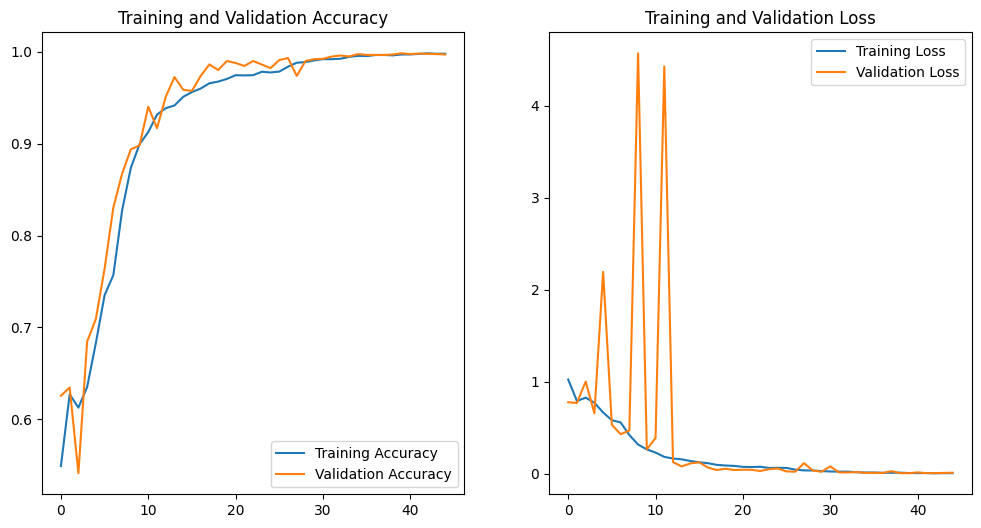

In [23]:
plot_history(history)